In [ ]:
import random

import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from skimage.feature import hog


from matplotlib import pyplot as plt

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

In [ ]:
def normalize_image(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply GaussianBlur to reduce noise and improve HOG performance
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)


    return image

def compute_gradients(image):
    # Compute gradients using Sobel operators
    gradient_x = cv2.Sobel(image, cv2.CV_32F, 1, 0, ksize=3)
    gradient_y = cv2.Sobel(image, cv2.CV_32F, 0, 1, ksize=3)

    # Compute magnitude and angle of gradients
    magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    angle = np.arctan2(gradient_y, gradient_x)

    # maxChan=np.argmax(magnitude,axis=2)
    # maxmag=np.zeros(maxChan.shape)
    # for r in range(maxChan.shape[0]):
    #   for c in range(maxChan.shape[1]):
    #     maxmag[r,c]=magnitude[r,c,maxChan[r,c]]

    # maxChan=np.argmax(angle,axis=2)
    # maxang=np.zeros(maxChan.shape)
    # for r in range(maxChan.shape[0]):
    #   for c in range(maxChan.shape[1]):
    #     maxang[r,c]=angle[r,c,maxChan[r,c]]

    # return maxmag, maxang
    return magnitude, angle


def createHist(AngArray,MagArray,BS=20,BINS=9):
    # Convert angles to degrees (0 to 180)
    AngArray = np.rad2deg(AngArray) % 180

    hist=np.zeros(BINS)
    for r in range(AngArray.shape[0]):
        for c in range(AngArray.shape[1]):
            binel,rem = np.divmod(AngArray[r,c],BS)
            weightR=rem*1.0/BS
            weightL=1-weightR
            deltaR=MagArray[r,c]*weightR
            deltaL=MagArray[r,c]*weightL
            binL=int(binel)
            binR=np.mod(binL+1,BINS)
            hist[binL]+=deltaL
            hist[binR]+=deltaR
    return hist

def hog_normalize_block(block, eps=1e-5):
    #L2
    out = block / np.sqrt(np.sum(block**2) + eps**2)
    return out

def compute_rectangular_hog(normalized_image, cell_size, block_size):
    # Normalize the image using OpenCV
    # normalized_image = normalize_image(image)

    # Compute gradients
    magnitude, angle = compute_gradients(normalized_image)
    magnitude=magnitude.astype(int)
    angle=angle.astype(int)

    # Define cell and block parameters
    cell_rows, cell_cols = cell_size
    b_row, b_col = block_size


    # Compute the number of cells in the image
    num_cells_row = normalized_image.shape[0] // cell_rows
    num_cells_col = normalized_image.shape[1] // cell_cols

    n_blocks_row = (num_cells_row - b_row) + 1
    n_blocks_col = (num_cells_col - b_col) + 1



    orientation_histogram = np.zeros(
        (num_cells_row, num_cells_col, 9), dtype=float
    )

    for row in range(num_cells_row - 1):
        for col in range(num_cells_col - 1):
            # Extract the cell region
            cell_magnitude = magnitude[row * cell_rows:(row + 1) * cell_rows,
                                       col * cell_cols:(col + 1) * cell_cols]
            cell_angle = angle[row * cell_rows:(row + 1) * cell_rows,
                               col * cell_cols:(col + 1) * cell_cols]

            # Compute the histogram for the cell
            cell_hist = createHist(cell_angle, cell_magnitude)

            orientation_histogram[row][col] = cell_hist

    normalized_blocks = np.zeros(
        (n_blocks_row, n_blocks_col, b_row, b_col, 9), dtype=float
    )

    for r in range(n_blocks_row):
        for c in range(n_blocks_col):
            block = orientation_histogram[r : r + b_row, c : c + b_col, :]
            normalized_blocks[r, c, :] = hog_normalize_block(block)

    normalized_blocks = normalized_blocks.ravel()
    return normalized_blocks



# Mục mới

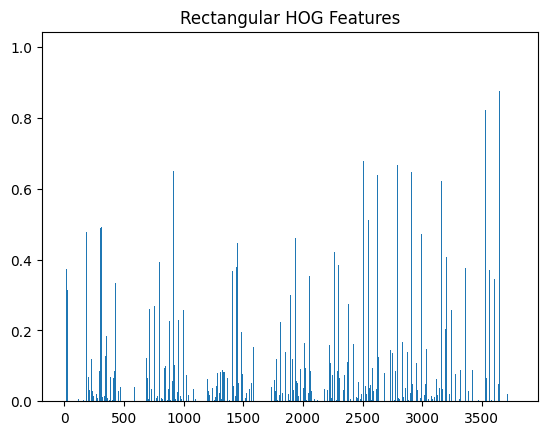

In [ ]:
# Load an image using OpenCV
image_path = '/content/sample_data/puppy_image_Resize.jpeg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = cv2.resize(image, (128,64))

# Specify parameters for rectangular HOG
cell_size = (8, 8)  # Rectangular cell size
block_size = (2, 2)

# Compute rectangular HOG features
rectangular_hog_features = compute_rectangular_hog(image, cell_size, block_size)

# Display the rectangular HOG features
plt.bar(range(len(rectangular_hog_features)), rectangular_hog_features)
plt.title('Rectangular HOG Features')
plt.show()

In [ ]:
from skimage.feature import hog

In [ ]:
image = cv2.imread(image_path)
imgray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = cv2.resize(imgray, (128,64))

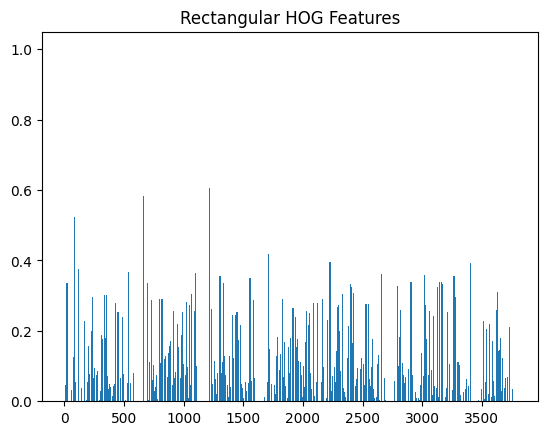

In [ ]:
fd1 =  hog(image, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2))
plt.bar(range(len(fd1)), fd1)
plt.title('Rectangular HOG Features')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import the necessary packages
import os

image_types = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")


def list_images(basePath, contains=None):
    return list_files(basePath, validExts=image_types, contains=contains)


def list_files(basePath, validExts=None, contains=None):
    # loop over the directory structure
    for (rootDir, dirNames, filenames) in os.walk(basePath):
        # loop over the filenames in the current directory
        for filename in filenames:
            # if the contains string is not none and the filename does not contain
            # the supplied string, then ignore the file
            if contains is not None and filename.find(contains) == -1:
                continue

            # determine the file extension of the current file
            ext = filename[filename.rfind("."):].lower()

            # check to see if the file is an image and should be processed
            if validExts is None or ext.endswith(validExts):
                # construct the path to the image and yield it
                imagePath = os.path.join(rootDir, filename)
                yield imagePath

imagePaths = list(list_images('/content/drive/MyDrive/ck/CK+48/'))

In [ ]:
def colortogray(im):
    image = cv2.imread(im)
    imgray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return imgray
def resizeImage(image, size):
    # cv2.imshow('Resized', cv2.resize(image, (size,size), interpolation=cv2.INTER_CUBIC))
    return cv2.resize(image, (size,size))
def feat_lab(imagePaths):

    features = []
    labels = []

    for imagePath in imagePaths:
        im = colortogray(imagePath)
        im = resizeImage(im,64)
        fd1 =  compute_rectangular_hog(im, cell_size=(8, 8),block_size=(4, 4))

        label = imagePath.split(os.path.sep)[-2]
        labels.append(label)
        features.append(fd1)

    features = np.array(features)
    labels = np.array(labels)
    return features,labels

In [ ]:
features,labels = feat_lab(imagePaths)


print("[INFO] The number of features ..." + str(features.shape[1]))

print("[INFO] The number of samples ..." + str(labels.shape[0]))

[INFO] The number of features ...3600
[INFO] The number of samples ...981


In [ ]:
svm_clf = SVC(kernel='rbf', gamma='scale', C= 10)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = classification_report(y_train, pred)
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")

    elif train==False:
        pred = clf.predict(X_test)
        clf_report = classification_report(y_test, pred)
        print("Test Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

################################################################################
################################################################################


R =random.randint(1,88)
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size= 0.3,random_state=40
                                                   )

print("[INFO] The number of images used in training ..." + str(X_train.shape[0]))
print("[INFO] The number of images used in testing ..." + str(X_test.shape[0]))


svm_clf.fit(X_train, y_train)

print_score(svm_clf, X_train, y_train, X_test, y_test, train=True)
print_score(svm_clf, X_train, y_train, X_test, y_test, train=False)


[INFO] The number of images used in training ...686
[INFO] The number of images used in testing ...295
Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

       anger       1.00      1.00      1.00        93
    contempt       1.00      1.00      1.00        36
     disgust       1.00      1.00      1.00       118
        fear       1.00      1.00      1.00        56
       happy       1.00      1.00      1.00       151
     sadness       1.00      1.00      1.00        57
    surprise       1.00      1.00      1.00       175

    accuracy                           1.00       686
   macro avg       1.00      1.00      1.00       686
weighted avg       1.00      1.00      1.00       686

_______________________________________________
Confusion Matrix: 
 [[ 93   0   0   0   0   0   0]
 [  0  36   0   0   0   0   0]
 [  0   0 118   0   0   0   0]
 [  0   0   0  56   0   0   0]